Biblioteki

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pickle
%matplotlib inline


In [2]:
reviews_test = pd.read_csv('train.csv', delimiter = ',', usecols=[4,5]);
reviews_test = reviews_test[reviews_test['Reviews'].notnull()]

rewiev_predict = pd.read_csv('test.csv', delimiter = ',', usecols=[0,4]);
# rewiev_predict = rewiev_predict[rewiev_predict['Reviews'].notnull()]
rewiev_predict = rewiev_predict.replace(np.nan, '', regex=True)
id_pred = rewiev_predict['Id']
# id_pred = pd.DataFrame(id_pred)
# rewiev_predict = rewiev_predict['Reviews']


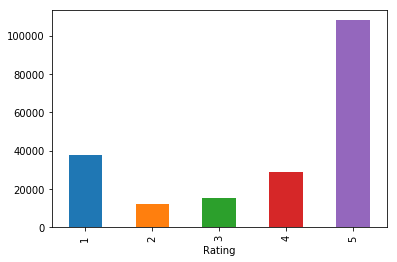

In [3]:
reviews_test.groupby('Rating').Reviews.count().plot.bar(ylim=0)
plt.show()

In [4]:
stemmer = PorterStemmer()
words = stopwords.words("english")

rewiev_predict['cleaned'] = rewiev_predict['Reviews'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
reviews_test['cleaned'] = reviews_test['Reviews'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [5]:
reviews_test.head(6)

,Reviews,Rating,cleaned
0,I feel so LUCKY to have found this used (phone...,5,i feel lucki found use phone us use hard phone...
1,"nice phone, nice up grade from my pantach revu...",4,nice phone nice grade pantach revu veri clean ...
2,Very pleased,5,veri pleas
3,It works good but it goes slow sometimes but i...,4,it work good goe slow sometim good phone i love
4,Great phone to replace my lost phone. The only...,4,great phone replac lost phone the thing volum ...
5,I already had a phone with problems... I know ...,1,i alreadi phone problem i know state use dang ...


In [6]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(reviews_test.iloc[:,2]).toarray()
final_features.shape

(68999, 58165)

In [7]:
X = reviews_test['cleaned']
Y = reviews_test['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier())])

model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

ytest = np.array(y_test)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [8]:
print(classification_report(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.88      0.91      0.89      9510
           2       0.91      0.74      0.82      3100
           3       0.88      0.72      0.79      3840
           4       0.86      0.65      0.74      7147
           5       0.88      0.97      0.92     27058

   micro avg       0.88      0.88      0.88     50655
   macro avg       0.88      0.80      0.83     50655
weighted avg       0.88      0.88      0.87     50655



In [9]:
print(confusion_matrix(ytest, model.predict(X_test)))

[[ 8643    96    99    83   589]
 [  410  2286    63    82   259]
 [  311    41  2749   129   610]
 [  198    39    96  4669  2145]
 [  243    40   102   477 26196]]


In [10]:
predicted = model.predict(rewiev_predict['cleaned'])

In [11]:
submission = pd.DataFrame({'Id':id_pred,'Rating' : predicted})

In [12]:
submission.to_csv('submission', sep=',', encoding='utf-8', index=False)